In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [9]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 99% 783M/788M [00:05<00:00, 89.0MB/s]
100% 788M/788M [00:05<00:00, 159MB/s] 


In [10]:
import zipfile
zip_ref = zipfile.ZipFile('/content/microsoft-catsvsdogs-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Importing Libraries

In [11]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data Preprocessing

In [12]:
class_names = ['Cat', 'Dog']

n_dogs = len(os.listdir('/content/PetImages/Cat'))
n_cats = len(os.listdir('/content/PetImages/Dog'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)


##### Great so I have a dataset that is perfectly **balanced**

### Creating Directories for Traning and Validation

In [13]:
try:
    os.mkdir('/content/cats-v-dogs')
    os.mkdir('/content/cats-v-dogs/training')
    os.mkdir('/content/cats-v-dogs/validation')
    os.mkdir('/content/cats-v-dogs/test')
    os.mkdir('/content/cats-v-dogs/training/cats')
    os.mkdir('/content/cats-v-dogs/training/dogs')
    os.mkdir('/content/cats-v-dogs/validation/cats')
    os.mkdir('/content/cats-v-dogs/validation/dogs')
    os.mkdir('/content/cats-v-dogs/test/cats')
    os.mkdir('/content/cats-v-dogs/test/dogs')
except OSError:
    print('Error failed to make directory')

In [14]:
#Define data path
CAT_DIR = '/content/PetImages/Cat'
DOG_DIR = '/content/PetImages/Dog'

TRAINING_DIR = "/content/cats-v-dogs/training/"
VALIDATION_DIR = "/content/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

# Define whether to include test split or not
INCLUDE_TEST = True

In [15]:
print(len(os.listdir('/content/cats-v-dogs/training/cats')))
print(len(os.listdir('/content/cats-v-dogs/training/dogs')))

print(len(os.listdir('/content/cats-v-dogs/validation/cats')))
print(len(os.listdir('/content/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/content/cats-v-dogs/test/cats')))
print(len(os.listdir('/content/cats-v-dogs/test/dogs')))

0
0
0
0
0
0


In [16]:
# now we will split the data into train and test data

# This function takes all images from one folder, removes corrupt (0-size) files, and shuffles them randomly.

# It splits the data into training (90%), and the remaining part into validation and test (50–50) if test is enabled.

# The images are then copied into their respective folders (training, validation, test).

# Finally, it prints a message confirming the split is done

In [17]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.9):
    """
    Splits the data into train validation and test sets

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for test
    include_test_split (boolen):  whether to include a test split or not
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    split_valid_test = int(split + (len(shuffled_files)-split)/2)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test] # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory

    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) # copy files into test directory
    print("Split sucessful!")

In [18]:
split_data(CAT_DIR, '/content/cats-v-dogs/training/cats', '/content/cats-v-dogs/validation/cats', '/content/cats-v-dogs/test/cats',INCLUDE_TEST, 0.9)
split_data(DOG_DIR, '/content/cats-v-dogs/training/dogs', '/content/cats-v-dogs/validation/dogs','/content/cats-v-dogs/test/dogs',INCLUDE_TEST, 0.9)

Split sucessful!
Split sucessful!


In [19]:
print(len(os.listdir('/content/cats-v-dogs/training/cats')))
print(len(os.listdir('/content/cats-v-dogs/training/dogs')))

print(len(os.listdir('/content/cats-v-dogs/validation/cats')))
print(len(os.listdir('/content/cats-v-dogs/validation/dogs')))


print(len(os.listdir('/content/cats-v-dogs/test/cats')))
print(len(os.listdir('/content/cats-v-dogs/test/dogs')))

11250
11250
625
625
625
625


### Creating Generators

In [20]:
# Normalising Data

train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)

In [21]:
train_generator = train_gen.flow_from_directory(
        '/content/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        '/content/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        '/content/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 22498 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.


In [22]:
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = next(generator)  # <-- use next() instead of generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i > n_images:  # slightly safer
            break

    plt.show()


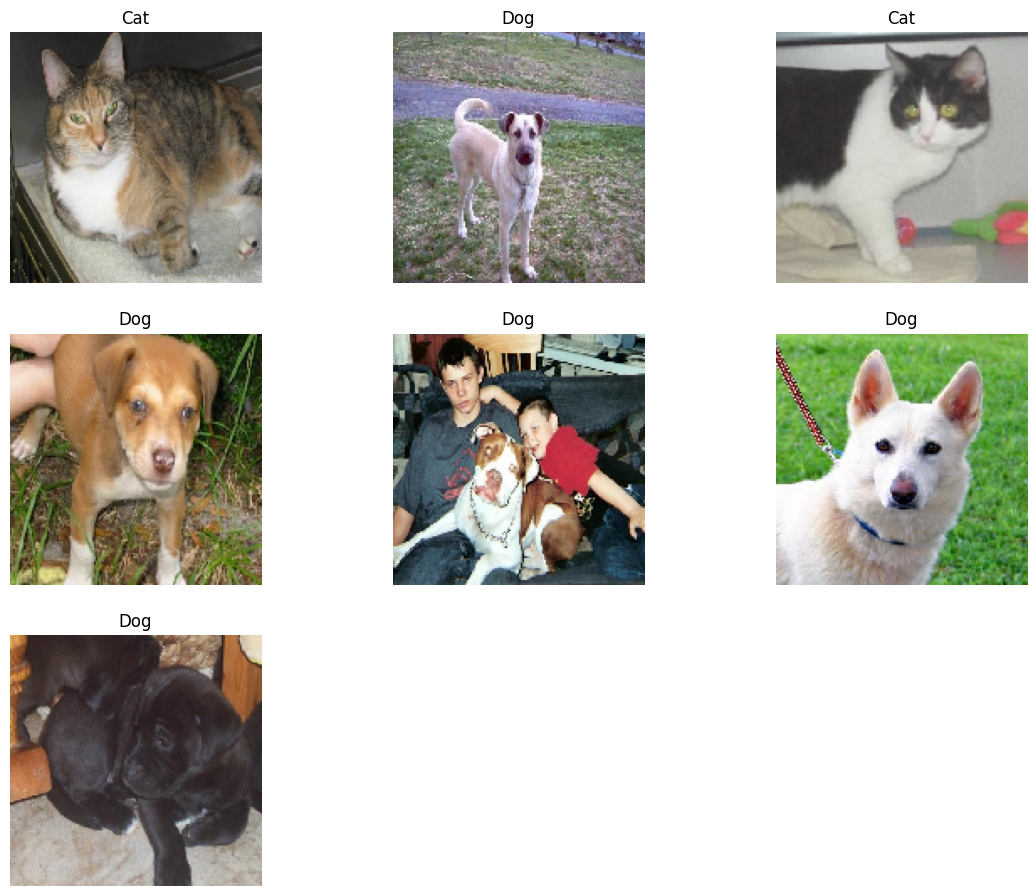

In [23]:
plot_data(train_generator,7)


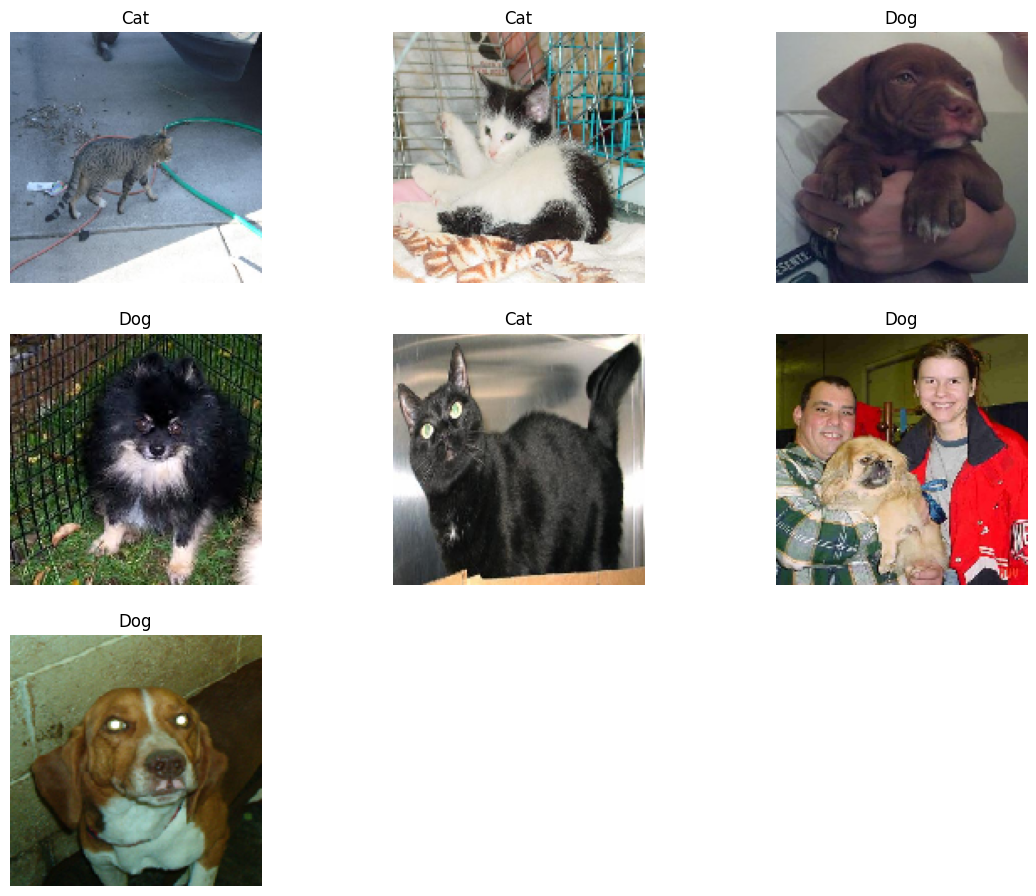

In [24]:
plot_data(train_generator,7)


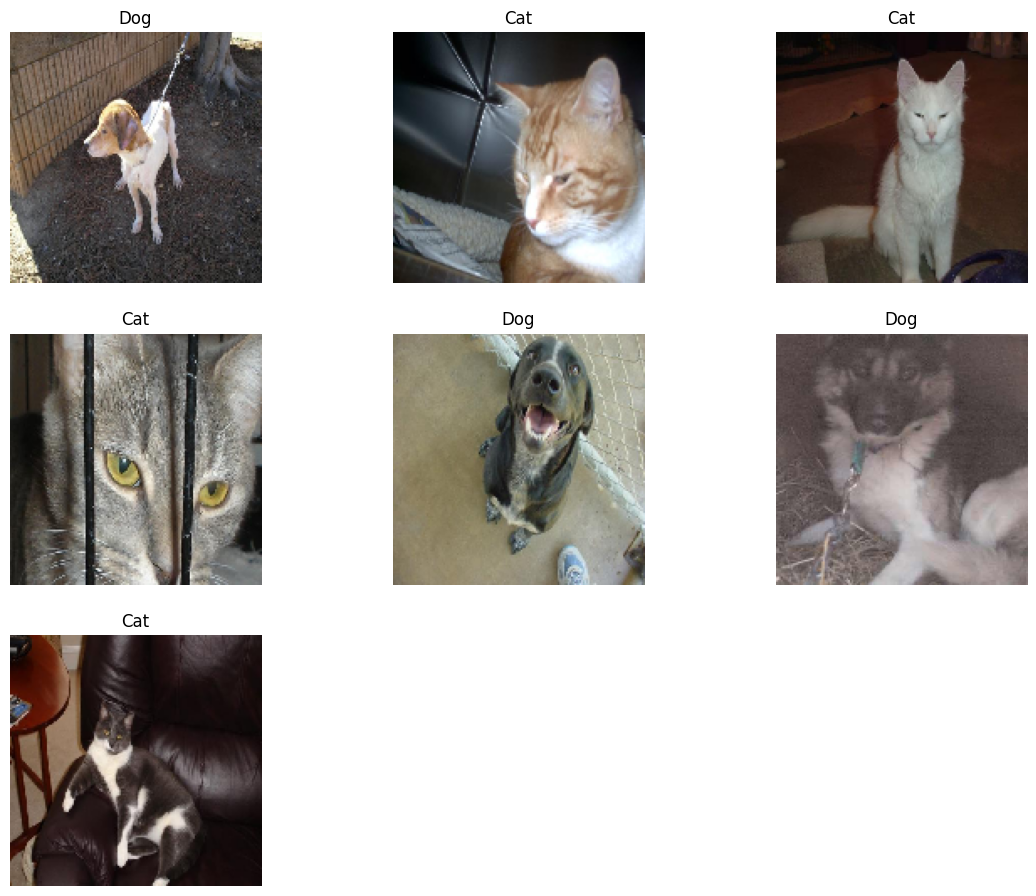

In [25]:
plot_data(train_generator,7)


### Model

In [26]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

In [27]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [28]:
r = model.fit(
        train_generator,
        epochs=10,#Training longer could yield better results
        validation_data=validation_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5235 - loss: 0.6890

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning:

Truncated File Read



352/352 ━━━━━━━━━━━━━━━━━━━━ 86s 197ms/step - accuracy: 0.5236 - loss: 0.6890 - val_accuracy: 0.5680 - val_loss: 0.6721
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 53s 151ms/step - accuracy: 0.6269 - loss: 0.6418 - val_accuracy: 0.6888 - val_loss: 0.5990
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 54s 154ms/step - accuracy: 0.6715 - loss: 0.6088 - val_accuracy: 0.6704 - val_loss: 0.6095
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step - accuracy: 0.6954 - loss: 0.5898 - val_accuracy: 0.6560 - val_loss: 0.6510
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 54s 152ms/step - accuracy: 0.7167 - loss: 0.5601 - val_accuracy: 0.7256 - val_loss: 0.5528
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 54s 154ms/step - accuracy: 0.7258 - loss: 0.5459 - val_accuracy: 0.7088 - val_loss: 0.5713
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step - accuracy: 0.7391 - loss: 0.5253 - val_accuracy: 0.7416 - val_loss: 0.5221
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 54s 152ms/step - accuracy: 0.7505 - loss: 0.5170 - val

### Evaluation

In [30]:
if INCLUDE_TEST:
    model.evaluate(test_generator)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6627 - loss: 0.6510


### Graphs

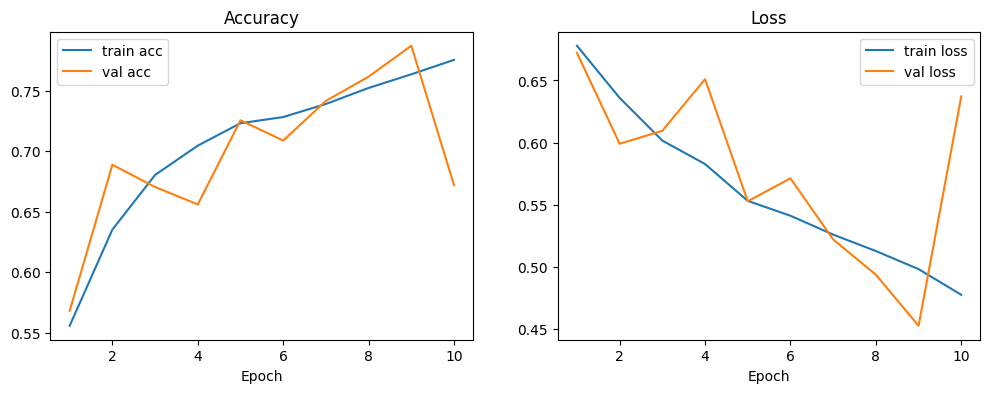

In [34]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, val_acc, label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

Evaluating on test set...
12/20 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6545 - loss: 0.6460

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning:

Truncated File Read



20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6619 - loss: 0.6415
Test loss: 0.6371  Test accuracy: 0.6720
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
Classification report:
              precision    recall  f1-score   support

        cats       0.50      0.80      0.61       625
        dogs       0.48      0.18      0.27       625

    accuracy                           0.49      1250
   macro avg       0.49      0.49      0.44      1250
weighted avg       0.49      0.49      0.44      1250



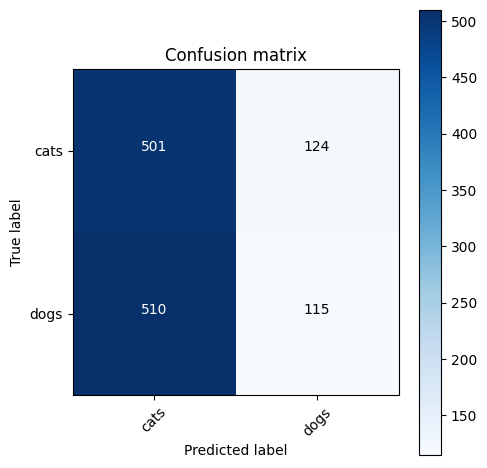

Saved model to cats_vs_dogs_model.keras


In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

if INCLUDE_TEST:
    print("Evaluating on test set...")
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test loss: {test_loss:.4f}  Test accuracy: {test_acc:.4f}")

    # Predictions and confusion matrix
    preds_proba = model.predict(test_generator)
    preds = np.argmax(preds_proba, axis=1)
    true = test_generator.classes
    labels = list(test_generator.class_indices.keys())  # e.g. ['cats','dogs']

    cm = confusion_matrix(true, preds)
    print("Classification report:")
    print(classification_report(true, preds, target_names=labels))

    # Plot confusion matrix
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# === 13) Save final model ===
model.save("cats_vs_dogs_model.keras")
print("Saved model to cats_vs_dogs_model.keras")